In [ ]:
!pip install rdkit catboost

In [4]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import export_graphviz
import graphviz

# Обработка данных. Добавление дескрипторов.

In [6]:
data = pd.read_excel('1400.xlsx')
data.head()

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0
1,1007-Ya-213,0.7,447.0,638.571429,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,51.0
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0
3,1009-As-106,8.3,500.0,60.240964,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,53.0
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0


In [7]:
def mol_dsc_calc(mols):
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in mols)

In [ ]:
descriptors = {"HeavyAtomCount": Descriptors.HeavyAtomCount,
               "NHOHCount": Descriptors.NHOHCount,
               "NOCount": Descriptors.NOCount,
               "NumHAcceptors": Descriptors.NumHAcceptors,
               "NumHDonors": Descriptors.NumHDonors,
               "NumHeteroatoms": Descriptors.NumHeteroatoms,
               "NumRotatableBonds": Descriptors.NumRotatableBonds,
               "NumValenceElectrons": Descriptors.NumValenceElectrons,
               "NumAromaticRings": Descriptors.NumAromaticRings,
               "NumAliphaticHeterocycles": Descriptors.NumAliphaticHeterocycles,
               "RingCount": Descriptors.RingCount,
               "MW": Descriptors.MolWt,
               "LogP": Descriptors.MolLogP,
               "MR": Descriptors.MolMR,
               "TPSA": Descriptors.TPSA}

# sklearn трансформер для использования в конвейерном моделировании
descriptors_transformer = FunctionTransformer(mol_dsc_calc)
descrs = descriptors_transformer.transform(data['SMILES'])

In [9]:
descrs.shape

(1468, 15)

In [10]:
full_df = pd.concat([data, descrs], axis=1)

In [12]:
full_df = full_df.drop(columns=['Title', 'SMILES', 'SI', 'Pictures'])

In [13]:
full_df.head(5)

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,...,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,LogP,MR,TPSA
0,2.7,500.0,195.307,2,1,32.59,14,1,2,2,...,2,2,80,0,0,2,195.306,2.2659,58.6168,32.59
1,0.7,447.0,195.307,2,1,32.59,14,1,2,2,...,2,2,80,0,0,2,195.306,2.2659,58.6168,32.59
2,9.9,144.0,250.431,1,0,15.60,18,0,2,2,...,2,5,104,0,0,2,250.430,3.6154,79.3190,15.60
3,8.3,500.0,222.377,1,0,15.60,16,0,2,2,...,2,3,92,0,0,2,222.376,2.8352,70.0850,15.60
4,39.4,143.0,239.361,2,0,29.54,17,0,3,3,...,3,3,98,0,0,2,239.359,2.3060,67.6630,29.54


In [14]:
y = full_df['IC50, mmg/ml']
X = full_df.drop(columns=['IC50, mmg/ml'])

In [15]:
X.head()

,"CC50-MDCK, mmg/ml",Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,LogP,MR,TPSA
0,500.0,195.307,2,1,32.59,14,1,2,2,1,2,2,80,0,0,2,195.306,2.2659,58.6168,32.59
1,447.0,195.307,2,1,32.59,14,1,2,2,1,2,2,80,0,0,2,195.306,2.2659,58.6168,32.59
2,144.0,250.431,1,0,15.60,18,0,2,2,0,2,5,104,0,0,2,250.430,3.6154,79.3190,15.60
3,500.0,222.377,1,0,15.60,16,0,2,2,0,2,3,92,0,0,2,222.376,2.8352,70.0850,15.60
4,143.0,239.361,2,0,29.54,17,0,3,3,0,3,3,98,0,0,2,239.359,2.3060,67.6630,29.54


In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Градиентный бустинг

In [17]:
train_pool = Pool(data=X_train, label=y_train)
eval_pool = Pool(data=X_eval, label=y_eval)

model = CatBoostRegressor()

model.fit(train_pool, eval_set=eval_pool, verbose=100)

Learning rate set to 0.051134
0:	learn: 97.0658718	test: 72.2934536	best: 72.2934536 (0)	total: 49.8ms	remaining: 49.8s
100:	learn: 58.1264190	test: 66.8655753	best: 61.8979865 (22)	total: 322ms	remaining: 2.87s
200:	learn: 51.0003017	test: 68.0035053	best: 61.8979865 (22)	total: 590ms	remaining: 2.35s
300:	learn: 45.4058588	test: 68.2884023	best: 61.8979865 (22)	total: 916ms	remaining: 2.13s
400:	learn: 40.6855100	test: 68.7787038	best: 61.8979865 (22)	total: 1.18s	remaining: 1.77s
500:	learn: 37.5423202	test: 69.2719316	best: 61.8979865 (22)	total: 1.46s	remaining: 1.46s
600:	learn: 34.1601887	test: 69.6242750	best: 61.8979865 (22)	total: 1.73s	remaining: 1.15s
700:	learn: 31.4322112	test: 70.0962251	best: 61.8979865 (22)	total: 1.99s	remaining: 848ms
800:	learn: 29.4514305	test: 70.5850100	best: 61.8979865 (22)	total: 2.25s	remaining: 559ms
900:	learn: 27.8898000	test: 70.9799461	best: 61.8979865 (22)	total: 2.6s	remaining: 286ms
999:	learn: 26.5274207	test: 71.4035856	best: 61.8979

In [18]:
y_pred = model.predict(X_test)

Mean Squared Error: 8439.589923471276
Mean Absolute Error: 47.54807814747693
R^2 Score: -0.5677536420482094


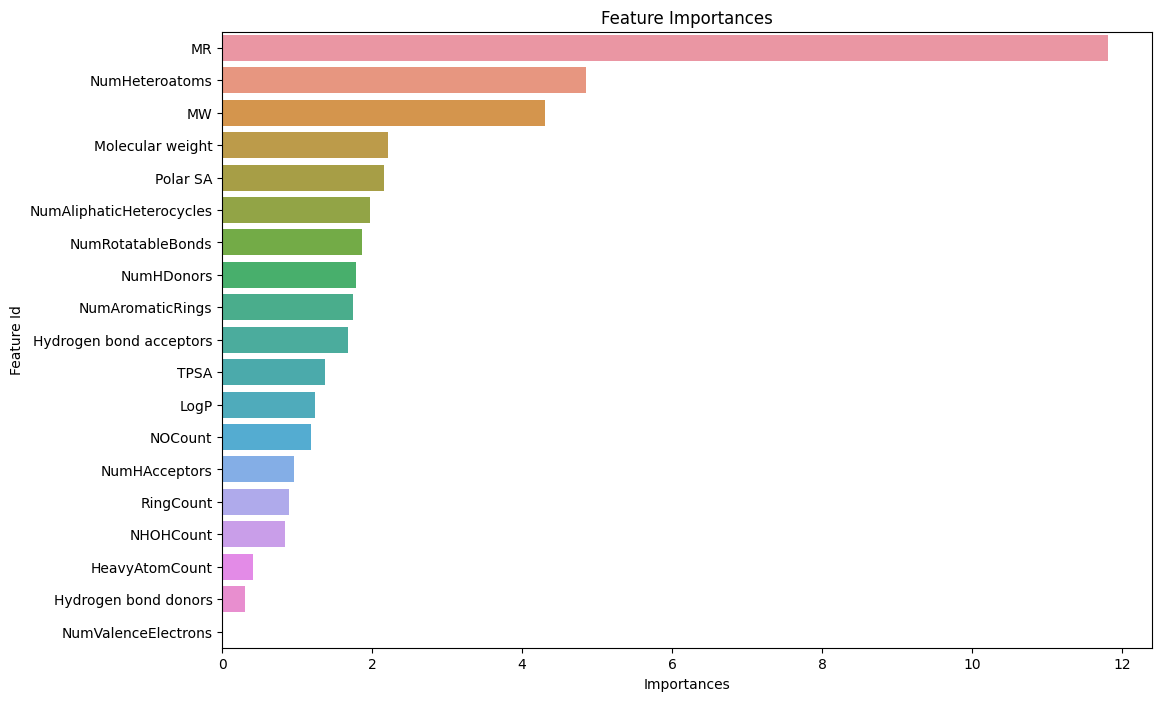

In [29]:

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))


importances = model.get_feature_importance(prettified=True)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importances', y='Feature Id', data=importances[1:])
plt.title('Feature Importances')
plt.show()

Можем видеть, что самая важная фича - CC50, напрямую связанная с расчетом IS, а вторая по важности - MR

# Решающие деревья

In [20]:
regr = DecisionTreeRegressor()
regr.fit(X_train, y_train)

DecisionTreeRegressor()

In [24]:
y_pred = regr.predict(X_test)

In [26]:
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 8439.589923471276
Mean Absolute Error: 47.54807814747693
R^2 Score: -0.5677536420482094


### Построение дерева и экспорт в .jpg

In [23]:
def visualize_tree(tree, feature_names, max_depth=None):
    dot_data = export_graphviz(tree, out_file=None,
                               max_depth=max_depth,
                               feature_names=feature_names,
                               filled=True, rounded=True,
                               special_characters=True)
    return graphviz.Source(dot_data)



graph = visualize_tree(regr, X_train.columns, max_depth=4)
graph.render("chem_tree", format="jpg")

'chem_tree.jpg'